### Zaawansowane Metody Uczenia Maszynowego

*Środowisko z poprzednich zajęć*

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
diamonds = sns.load_dataset("diamonds")
diamonds = pd.DataFrame(diamonds)

diamonds = diamonds[diamonds["cut"] != "Very Good"]

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, PowerTransformer, StandardScaler
from sklearn.linear_model import LogisticRegression

preprocesor = ColumnTransformer(
    transformers=[
        ("categorical", OneHotEncoder(handle_unknown="ignore"), ["color", "clarity"]),
        ("power_transform", PowerTransformer(), ["price", "carat"]),
        ("scale", StandardScaler(), ["x", "y", "z", "depth", "table", "price", "carat"])
    ]
)

pipeline = Pipeline(
    steps=[
        ("preprocess", preprocesor),
        ("model", LogisticRegression(max_iter=2000))
    ]
)


y = diamonds.cut
X = diamonds.drop(["cut"], axis=1)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
cm

array([[ 193,   67,   40,   83],
       [  46,  445,  336,  438],
       [   1,   22, 5022,  419],
       [   6,   97,  569, 2681]], dtype=int64)

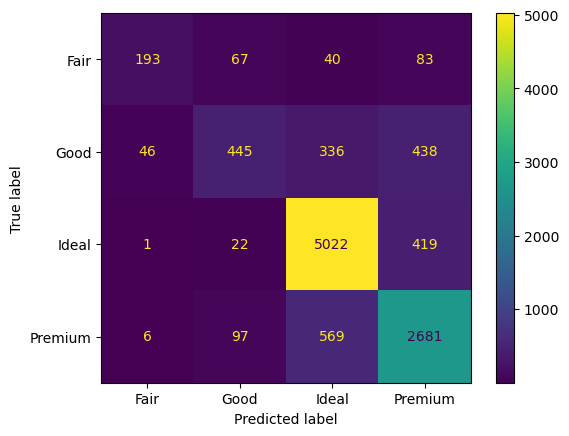

In [2]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=pipeline.classes_)
disp.plot()

In [3]:
y_score = pipeline.predict_proba(X_test)

In [4]:
from sklearn.preprocessing import LabelBinarizer

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
y_onehot_test.shape  # (n_samples, n_classes)

(10465, 4)

In [5]:
class_of_interest = "Good"
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
class_id

1

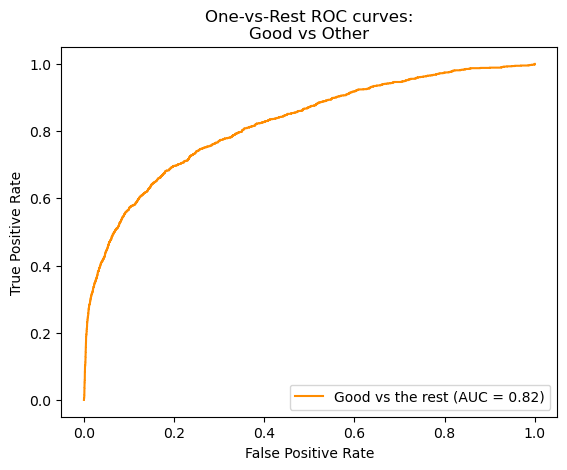

In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

display = RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    y_score[:, class_id],
    name=f"{class_of_interest} vs the rest",
    color="darkorange",
    # plot_chance_level=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="One-vs-Rest ROC curves:\nGood vs Other",
)

https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

#### Laboratorium 3
*Inspirowane materiałami Kamila Kmity.*

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

In [8]:
rng = np.random.default_rng(2024)

### Zadanie 1
----
Wygeneruj $200$ obserwacji pseudolosowych takich, że

\begin{equation}
Y = \beta_0 + \beta_1 \cdot X_1 + \beta_2 \cdot X_2 + \beta_3 \cdot X_3 + \epsilon,
\end{equation}

gdzie

* $\beta = (50, -2, 2.25, 3)$,
* $X_1 \sim \mathcal{N}(98, 10)$,
* $X_2 \sim \mathcal{N}(50, 5)$,
* $X_3 \sim \mathcal{N}(231, 12)$,
* $\epsilon \sim \mathcal{N}(0, 4.75)$.

[Jak losować liczby w `numpy`.](https://numpy.org/doc/stable/reference/random/generator.html)


In [9]:
np.concatenate([
    rng.normal(98, 10, size=(200, 1)),
    rng.normal(50, 5, size=(200, 1)),
    rng.normal(231, 12, size=(200, 1)),
    rng.normal(0, 4.75, size=(200, 1))
])



array([[ 1.08288569e+02],
       [ 1.14419200e+02],
       [ 1.09467195e+02],
       [ 8.82682048e+01],
       [ 8.40719990e+01],
       [ 9.86719636e+01],
       [ 1.06613509e+02],
       [ 1.03091868e+02],
       [ 1.16102856e+02],
       [ 1.05508435e+02],
       [ 1.04397596e+02],
       [ 9.06867748e+01],
       [ 8.69228296e+01],
       [ 1.12844056e+02],
       [ 9.84891240e+01],
       [ 1.06115201e+02],
       [ 8.42357716e+01],
       [ 9.36362926e+01],
       [ 8.50890837e+01],
       [ 9.02432132e+01],
       [ 1.07030631e+02],
       [ 8.31941867e+01],
       [ 9.26590717e+01],
       [ 9.96378857e+01],
       [ 9.13152970e+01],
       [ 9.54771024e+01],
       [ 9.57813846e+01],
       [ 1.02181386e+02],
       [ 9.36874545e+01],
       [ 1.00722607e+02],
       [ 9.85681920e+01],
       [ 1.02245693e+02],
       [ 1.00249434e+02],
       [ 1.14576841e+02],
       [ 9.13632393e+01],
       [ 1.09991872e+02],
       [ 9.39738757e+01],
       [ 8.84207383e+01],
       [ 1.1

In [10]:
data = pd.DataFrame({
    "X1": rng.normal(98, 10, size=(200)),
    "X2": rng.normal(50, 5, size=(200)),
    "X3": rng.normal(231, 12, size=(200)),
    "e": rng.normal(0, 4.75, size=(200))
})

data["Y"] = 50 - 2*data.X1 + 2.25*data.X2 +3*data.X3 +data.e

In [11]:
data

,X1,X2,X3,e,Y
0,95.682553,54.405202,244.395441,0.222533,714.455456
1,111.921976,45.780001,240.865701,0.441441,652.199595
2,104.961351,40.147405,232.031978,5.617064,632.121955
3,107.741274,52.086173,235.568786,1.141386,659.559085
4,98.935112,43.797701,207.826163,2.803120,576.956212
...,...,...,...,...,...
195,87.135644,55.371737,226.637962,6.188900,686.417905
196,92.915263,47.430605,237.187084,3.965957,686.415544
197,103.137529,49.159109,233.794650,-2.295054,653.421833
198,95.962394,50.416661,260.249536,0.049925,752.311233


### Regresja liniowa

Cel: znalezienie optymalnego wektora parametrów
 $\beta = (\beta_0, \beta_1, \ldots, \beta_p)^T$.

W tym celu definiujemy funkcję ryzyka $L(\beta)$ i szukamy

$$
\begin{equation}
\hat{\beta} = \underset{\beta}{\text{arg min}} \quad
L(\beta)
\end{equation}
$$

Powszechnie stosowana funkcja ryzyka
([o przydatnych statystycznie właściwościach](https://en.wikipedia.org/wiki/Ordinary_least_squares#Properties)) to *Mean Squared Error* MSE

$$
\begin{align}
L(\beta) &= \text{MSE}(\beta; X, y)\\
&= \sum\limits_{i=1}^n (\hat{y}_i - y_i)^2 \\
&= \sum\limits_{i=1}^n ({\beta} \mathbf{x}_i - y_i)^2
\qquad \text{where }\mathbf{x}_i \in R^p
\\
&= {\lVert X {\beta} - Y \rVert}^2
= (X {\beta} - Y)^T (X {\beta} - Y)
\end{align}
$$

Jak wyznaczyć $\hat{\beta}$?

$$\nabla_{\beta} L(\beta)=0$$
$$\nabla_{\beta} L(\beta)=\nabla_{\beta}(X \beta - Y)'(X \beta - Y) = -2X'Y + 2X'X \beta$$

$$\hat{\beta} = (X'X)^{-1}X'Y$$

### Zadanie 2
----
Zaimplementuj klasę `Regression` z metodą `fit` i dopasuj model regresji liniowej do wysymulowanych danych `data`.

Szkielet rozwiązania

```python
class Regression:
    def __init__(self, ...)
        self.weights = None
        ...

    def fit(self, X, y):
        ...
```

In [12]:
class Regression:
    def __init__(self):
        self.weights = None
    
    def fit(self, X, y):
        self.weights = np.linalg.inv(X.T @ X) @ (X.T @ y)

In [13]:
regression1 = Regression()

In [14]:
regression1.fit(data.loc[:, ["X1", "X2", "X3"]], data.Y.values)

In [15]:
print(regression1.weights)

[-1.89177603  2.42389216  3.12947266]


### Zadanie 3
---
W powyższym przykładzie nie zawarliśmy wyrazu wolnego *intercept* . Możemy dołączyć wyraz wolny poprzez rozszerzenie macierzy:

$X := [\mathbf{1} | X]$,

Zmodyfikuj metody `__init__` oraz `fit` klasy `Regression` tak, żeby użytkownik miał wybór: użyć intercept lub nie.

Szkielet rozwiązania

```python
class Regression:
    def __init__(self, intercept=False)
        self.weights = None
        self.intercept = intercept

    def fit(self, X, y):
        if self.intercept:
            pass
        pass
```

In [16]:
class Regression:
    def __init__(self, intercept=False):
        self.weights = None
        self.intercept = intercept
    
    def fit(self, X, y):
        if self.intercept:    
            X = np.hstack((np.ones((X.shape[0], 1)), X))
        self.weights = np.linalg.inv(X.T @ X) @ (X.T @ y)


In [17]:
reg = Regression(intercept=True)
reg.fit(data.loc[:, ["X1", "X2", "X3"]], data.Y.values)

In [18]:
print(reg.weights)

[49.35446716 -1.97154333  2.23857635  2.99066706]


## Reprezentacja regresji liniowej jako prostej sieci neuronowej

*Note*
[Zapoznaj się z krótkim wprowadzeniem do `Keras`.](https://keras.io/about/)

### Zadanie 4
Zaimplementuj model regresji używając sieci neuronowej.

W modelu:
* $x$ to wektor kolumnowy `[[X1], [X2], [X3]]` (czyli macierz `np.array` o wymiarze 3x1),
* $W$ = `[[w1, w2, w3]]` to macierz o wymiarze 1x3,
* $b \in R$,
* $z=Wx + b$ to warstwa typu `tf.keras.layers.Dense`,
* funkcja aktywacji $\sigma = Id$, co zapewnia nam model liniowy.

Utwórz model `model1` korzystając z biblioteki `Keras`, korzystając ze szkieletu poniżej. Korzystaj z *Sequential API*.

```python
model1 = ...

model1.add(tf.keras.Input(shape=...))

model1.add(
    tf.keras.layers.Dense(
        ..., 
        activation=...
    )
)
```

In [19]:
model1 = tf.keras.Sequential()

model1.add(tf.keras.Input(shape=(3,)))

model1.add(
    tf.keras.layers.Dense(
        1,
        activation=tf.keras.activations.linear
    )
)


In [20]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 4         
                                                                 
Total params: 4 (16.00 Byte)
Trainable params: 4 (16.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [21]:
model1.weights

[<tf.Variable 'dense/kernel:0' shape=(3, 1) dtype=float32, numpy=
 array([[-0.21081924],
        [ 0.37984693],
        [ 0.645185  ]], dtype=float32)>,
 <tf.Variable 'dense/bias:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>]

In [22]:
from keras.callbacks import LambdaCallback
print_weights = LambdaCallback(on_epoch_end=lambda batch,
                               logs: print(model1.layers[0].get_weights))

In [23]:
model1.compile(optimizer="sgd", loss="mse")


In [24]:
model1.fit(
    data.loc[:, ["X1", "X2", "X3"]],
    data.loc[:,["Y"]],
    epochs = 5,
    verbose = 1,
    callbacks = [print_weights],
    batch_size=20
)

Epoch 1/5

10/10 [==============================] - 1s 3ms/step - loss: inf     
Epoch 2/5
10/10 [==============================] - 0s 4ms/step - loss: nan
Epoch 3/5
10/10 [==============================] - 0s 3ms/step - loss: nan
Epoch 4/5
10/10 [==============================] - 0s 2ms/step - loss: nan
Epoch 5/5
10/10 [==============================] - 0s 2ms/step - loss: nan


[Problem ekspoludjącego gradientu](https://en.wikipedia.org/wiki/Vanishing_gradient_problem)